# INF2178 Assignment 2
Samantha Chui (1002369126)

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
%pip install bioinfokit
from bioinfokit.analys import stat
import math

In [52]:
filepath = '/Users/schui/Documents/Master of Information/INF2178/'
df = pd.read_excel(filepath + 'INF2178_A2_data.xlsx', index_col=0)
childcare_df = df.copy() # make a copy of the df so that the original df remains untouched
childcare_df.head()

,LOC_ID,LOC_NAME,AUSPICE,ADDRESS,PCODE,ward,bldg_type,BLDGNAME,IGSPACE,TGSPACE,PGSPACE,KGSPACE,SGSPACE,TOTSPACE,subsidy,cwelcc_flag
_id,,,,,,,,,,,,,,,,
1,1013,Lakeshore Community Child Care Centre,Non Profit Agency,101 SEVENTH ST,M8V 3B5,3,Public Elementary School,Seventh Street Public School,0,20,32,52,60,164,Y,Y
2,1014,Alternative Primary School Parent Group,Non Profit Agency,1100 SPADINA RD,M5N 2M6,8,Public Elementary School,North Preparatory Public School,0,0,12,26,45,83,Y,Y
3,1015,Cardinal Leger Child Care Centre (Scarborough),Non Profit Agency,600 MORRISH RD,M1C 4Y1,25,Catholic Elementary School,Cardinal Leger Catholic School,0,10,16,26,50,102,Y,Y
4,1016,George Brown - Richmond Adelaide Childcare Centre,Non Profit Agency,130 ADELAIDE ST W,M5H 3P5,10,Other,NaN,10,15,40,0,0,65,Y,Y
5,1017,Woodland Nursery School (Warden Woods Communit...,Non Profit Agency,1 FIRVALLEY CRT,M1L 1N8,20,High Rise Apartment,NaN,0,10,16,0,0,26,Y,Y


In [53]:
# check type of each column to see if anything needs to be changed
childcare_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1063 entries, 1 to 1063
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   LOC_ID       1063 non-null   int64 
 1   LOC_NAME     1063 non-null   object
 2   AUSPICE      1063 non-null   object
 3   ADDRESS      1063 non-null   object
 4   PCODE        1063 non-null   object
 5   ward         1063 non-null   int64 
 6   bldg_type    1063 non-null   object
 7   BLDGNAME     715 non-null    object
 8   IGSPACE      1063 non-null   int64 
 9   TGSPACE      1063 non-null   int64 
 10  PGSPACE      1063 non-null   int64 
 11  KGSPACE      1063 non-null   int64 
 12  SGSPACE      1063 non-null   int64 
 13  TOTSPACE     1063 non-null   int64 
 14  subsidy      1063 non-null   object
 15  cwelcc_flag  1063 non-null   object
dtypes: int64(8), object(8)
memory usage: 141.2+ KB


In [54]:
# change columns LOC_ID and ward to type str
childcare_df['LOC_ID'] = childcare_df['LOC_ID'].astype(str)
childcare_df['ward'] = childcare_df['ward'].astype(str)

In [55]:
# rename columns to more meaningful phrases
new_names = ['ID', 'Name', 'Agency_Type', 'Address', 'Postal_Code', 'Ward', 'Building_Type', 'Building_Name',\
             'Infants', 'Toddlers', 'Preschool', 'Kindergarten', 'Grade_School', 'Total_Space', 'Subsidy', 'CWELCC']
old_names = list(childcare_df)
# map old to new names in a dict, then apply to df
name_dict = dict(map(lambda key, val: (key, val), old_names, new_names))

childcare_df.rename(columns=name_dict, inplace=True)

In [56]:
# create a function that returns the number of unique categories in a column, as defined by columns of type str
# gives us an idea of the num of 'treatment levels' in a column and which ones could be used for analysis
def unique_categories(df):
    dict_n = {}
    for col, val in df.transpose().iterrows():
        if df.dtypes[col] == 'object':
            dict_n[col] = [df[col].nunique()]
    unique_n = pd.DataFrame(dict_n) # return results as a table
    unique_n = unique_n.T
    unique_n.reset_index(inplace=True)
    unique_n.columns = ['Column', '# of Categories']
    return unique_n

unique_categories(childcare_df)

,Column,# of Categories
0,ID,1063
1,Name,1058
2,Agency_Type,3
3,Address,1032
4,Postal_Code,998
5,Ward,25
6,Building_Type,30
7,Building_Name,691
8,Subsidy,2
9,CWELCC,2


#### One-Way ANOVA
Does the number of spaces that a child care centre offers differ by age group? \
Null Hypothesis: The number of spaces offered does NOT differ by age group \
Alternate Hypothesis: The number of spaces offered DOES differ by age group

In [57]:
# create df of age groups
age_group = childcare_df[['Infants', 'Toddlers', 'Preschool', 'Kindergarten', 'Grade_School']].copy()

# filter out rows where number of spaces is 0 as it is technically NA (care is not offered for this group)
def replace_nan(df):
    for col in df:
        df[col] = df[col].apply(lambda x: np.nan if x == 0 else x)
    return df

replace_nan(age_group)

,Infants,Toddlers,Preschool,Kindergarten,Grade_School
_id,,,,,
1,NaN,20.0,32.0,52.0,60.0
2,NaN,NaN,12.0,26.0,45.0
3,NaN,10.0,16.0,26.0,50.0
4,10.0,15.0,40.0,NaN,NaN
5,NaN,10.0,16.0,NaN,NaN
...,...,...,...,...,...
1059,NaN,NaN,NaN,52.0,60.0
1060,NaN,25.0,35.0,NaN,NaN
1061,NaN,25.0,24.0,NaN,NaN


In [62]:
# get summary statistics of each age group, ignoring NA values
def summary_table(df):
  summary_table = pd.DataFrame({'Statistic': ['Count', 'Mean', 'Median', 'Min_Value', 'Max_Value', 'Quartile_1', 'Quartile_3']})
  for col in df:
    col_stats = [np.sum(df[col].count()), np.round(np.nanmean(df[col]), 3), round(np.nanmedian(df[col]), 3), round(df[col].min(), 3),\
                 round(df[col].max(), 3), round(np.nanquantile(df[col], 0.25), 3), round(np.nanquantile(df[col], 0.75), 3)]
    summary_table[col] = col_stats
  return summary_table

summary_table(age_group)

,Statistic,Infants,Toddlers,Preschool,Kindergarten,Grade_School
0,Count,359.000,670.000,854.000,461.000,505.000
1,Mean,11.538,18.404,30.196,32.876,45.596
2,Median,10.000,15.000,24.000,26.000,30.000
3,Min_Value,4.000,2.000,1.000,5.000,6.000
4,Max_Value,30.000,90.000,144.000,130.000,285.000
5,Quartile_1,10.000,10.000,20.000,24.000,30.000
6,Quartile_3,10.000,20.000,38.000,48.000,60.000


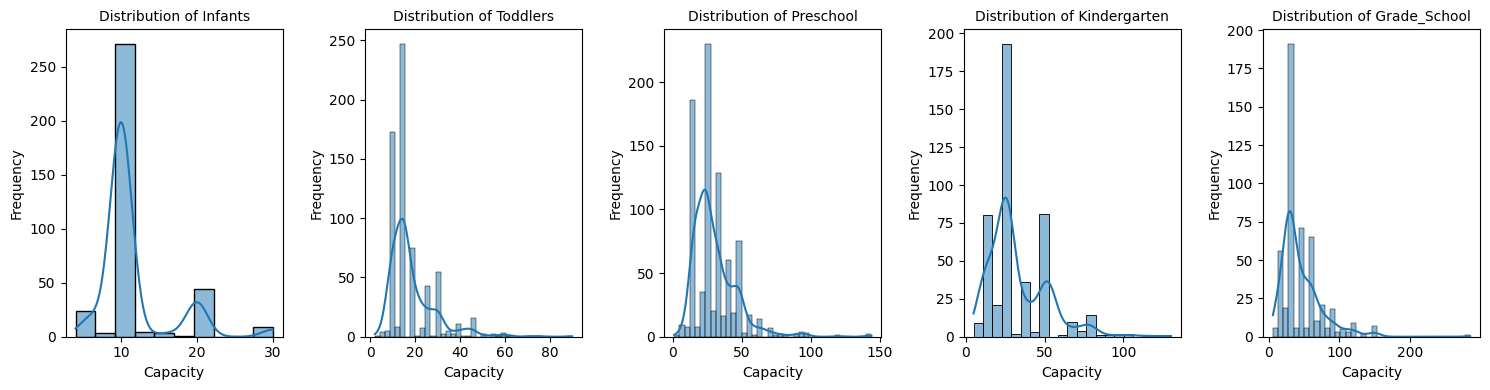

In [63]:
# plot histogram of the treatment level (age group)
def histogram_plot(df):
    fig, ax = plt.subplots(1, len(df.columns), figsize = [15, 4])
    ax_n = 0
    categories = list(df.columns)
    for col in df:
        sns.histplot(df[col], bins = 'auto', kde = True, ax = ax[ax_n])
        ax[ax_n].set_title('Distribution of %s' % categories[ax_n], fontsize = 10)
        ax[ax_n].set_xlabel('Capacity')
        ax[ax_n].set_ylabel('Frequency')
        ax_n += 1
    plt.tight_layout()
    plt.show()

histogram_plot(age_group)

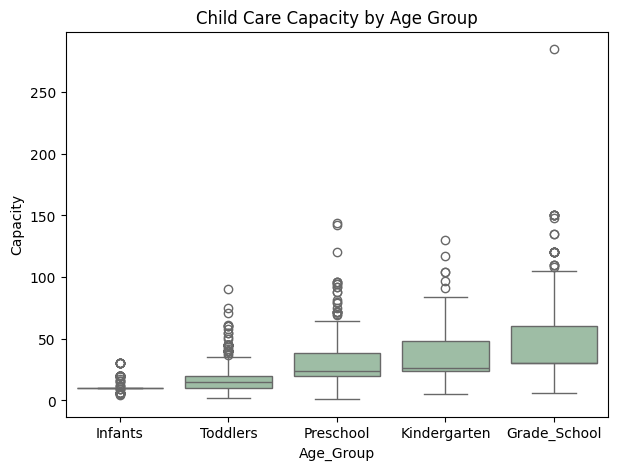

In [64]:
# plot boxplot

# create merged df
age_melt = pd.melt(age_group)
age_melt.columns = ['Age_Group', 'Value']
age_melt.dropna(inplace=True)
age_melt.reset_index(drop=True, inplace=True)

plt.figure(figsize=[7, 5])
ax = sns.boxplot(x = 'Age_Group', y = 'Value', data = age_melt, color = '#99c2a2')
ax.set_ylabel('Capacity')
ax.set_title('Child Care Capacity by Age Group')

plt.show()

In [65]:
# create a function to round a number to 3 decimal places
def round_num(val):
    if val < 0.001:
        val = '< 0.001'
    else:
        val = round(val, 3)
    return val

# create similar function but applies to a whole table
def round_table(df):
    rounded_df = df.copy()
    for col in rounded_df:
        if (rounded_df[col].dtype == 'float64') or (rounded_df[col].dtype == 'int64'):
            for x in range(0, len(rounded_df[col])):
                if not math.isnan(rounded_df[col][x]):
                    rounded_df[col][x] = round_num(rounded_df[col][x])
    return rounded_df

In [66]:
# calculate ANOVA
res = stat()
res.anova_stat(df = age_melt, res_var = 'Value', anova_model = 'Value ~ C(Age_Group)')
round_table(res.anova_summary)

,df,sum_sq,mean_sq,F,PR(>F)
C(Age_Group),4.0,330261.920,82565.480,264.388,< 0.001
Residual,2844.0,888150.516,312.289,NaN,NaN


In [67]:
# post-hoc testing using Tukey's HSD
res = stat()
res.tukey_hsd(df=age_melt, res_var='Value', xfac_var='Age_Group', anova_model='Value ~ C(Age_Group)')
round_table(res.tukey_summary)

/usr/local/lib/python3.10/dist-packages/bioinfokit/analys.py:421: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]
/usr/local/lib/python3.10/dist-packages/bioinfokit/analys.py:421: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]
/usr/local/lib/python3.10/dist-packages/bioinfokit/analys.py:421: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to 

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,Infants,Toddlers,6.867,3.712,10.022,8.402,0.001
1,Infants,Preschool,18.658,15.624,21.692,23.738,0.001
2,Infants,Kindergarten,21.339,17.943,24.734,24.260,0.001
3,Infants,Grade_School,34.058,30.729,37.388,39.482,0.001
4,Toddlers,Preschool,11.791,9.302,14.280,18.284,0.001
5,Toddlers,Kindergarten,14.472,11.553,17.391,19.139,0.001
6,Toddlers,Grade_School,27.192,24.349,30.034,36.926,0.001
7,Preschool,Kindergarten,2.681,< 0.001,5.469,3.712,0.066
8,Preschool,Grade_School,15.400,12.693,18.108,21.955,0.001
9,Kindergarten,Grade_School,12.720,9.613,15.827,15.802,0.001


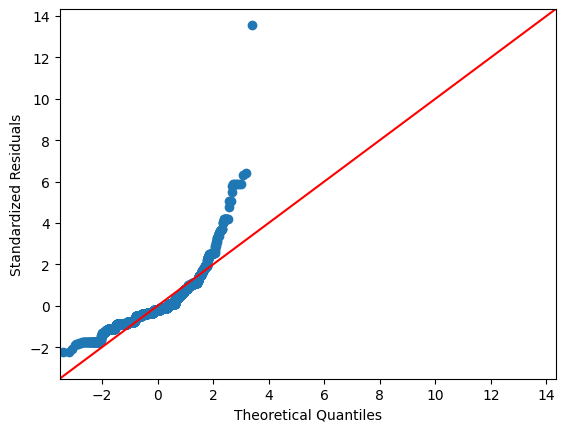

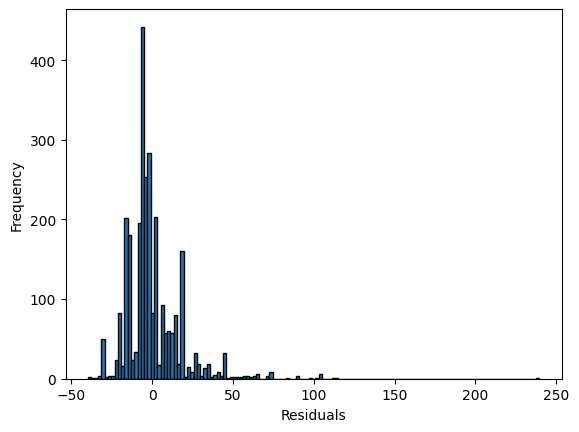

In [68]:
# testing ANOVA assumptions

# assumption 1: residuals follow a normal distribution (using qq plot and histogram)
sm.qqplot(res.anova_std_residuals, line='45')
#plt.title('Scatterplot Distribution of Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Standardized Residuals')
plt.show()

plt.hist(res.anova_model_out.resid, bins='auto', histtype='bar', ec='k')
#ax[1].set_title('Histogram Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

In [70]:
# testing assumption 1 using Shapiro-Wilk Test
w, pvalue = stats.shapiro(res.anova_model_out.resid)
shapiro_test = pd.DataFrame({'Parameter': ['Test Statistic', 'p-value'], 'Value': [w, pvalue]})
round_table(shapiro_test)

<ipython-input-65-c67f25b56975>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rounded_df[col][x] = round_num(rounded_df[col][x])


,Parameter,Value
0,Test Statistic,0.815
1,p-value,< 0.001


In [71]:
# assumption 2: samples are of equal variance (using Levene's Test)
res = stat()
res.levene(df=age_melt, res_var='Value', xfac_var='Age_Group')
round_table(res.levene_summary)

<ipython-input-65-c67f25b56975>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rounded_df[col][x] = round_num(rounded_df[col][x])


,Parameter,Value
0,Test statistics (W),86.13
1,Degrees of freedom (Df),4.0
2,p value,< 0.001


#### Two-Way ANOVA
Does total centre capacity differ by ward and availability of subsidy? \
Null Hypothesis: Total spaces does NOT differ by ward or subsidy \
Alternate Hypothesis: Total spaces DOES differ by ward and/or subsidy

In [72]:
ward_subsidy = childcare_df[['Ward', 'Subsidy', 'Total_Space']].copy()
ward_subsidy.reset_index(drop=True, inplace=True)
ward_subsidy['Subsidy'] = ward_subsidy['Subsidy'].replace({'Y': 'Available', 'N': 'Unavailable'})
ward_subsidy['Ward'] = ward_subsidy['Ward'].astype('int64')
ward_subsidy

,Ward,Subsidy,Total_Space
0,3,Available,164
1,8,Available,83
2,25,Available,102
3,10,Available,65
4,20,Available,26
...,...,...,...
1058,6,Available,112
1059,15,Unavailable,60
1060,13,Unavailable,49
1061,8,Available,56


In [73]:
ward_subsidy_2 = pd.pivot_table(ward_subsidy, columns=['Ward', 'Subsidy'], values='Total_Space', aggfunc='count')
ward_subsidy_2 = ward_subsidy_2.T
ward_subsidy_2.sort_index(level=0, inplace=True)
ward_subsidy_2

Total_Space
Ward Subsidy                 
1    Available             29
     Unavailable            3
2    Available             32
     Unavailable           16
3    Available             34
     Unavailable           27
4    Available             26
     Unavailable           30
5    Available             32
     Unavailable            4
6    Available             34
     Unavailable            9
7    Available             28
     Unavailable            5
8    Available             24
     Unavailable           29
9    Available             31
     Unavailable            8
10   Available             33
     Unavailable           13
11   Available             25
     Unavailable           15
12   Available             22
     Unavailable           25
13   Available             22
     Unavailable            6
14   Available             34
     Unavailable           24
15   Available             24
     Unavailable           24
16   Available             29
     Unavailable           16
17   Available             32
     Unavailable           13
18   Available             16
     Unavailable           15
19   Available             36
     Unavailable           24
20   Available             32
     Unavailable           10
21   Available             32
     Unavailable            5
22   Available             30
     Unavailable            9
23   Available             23
     Unavailable            7
24   Available             35
     Unavailable            2
25   Available             23
     Unavailable            6

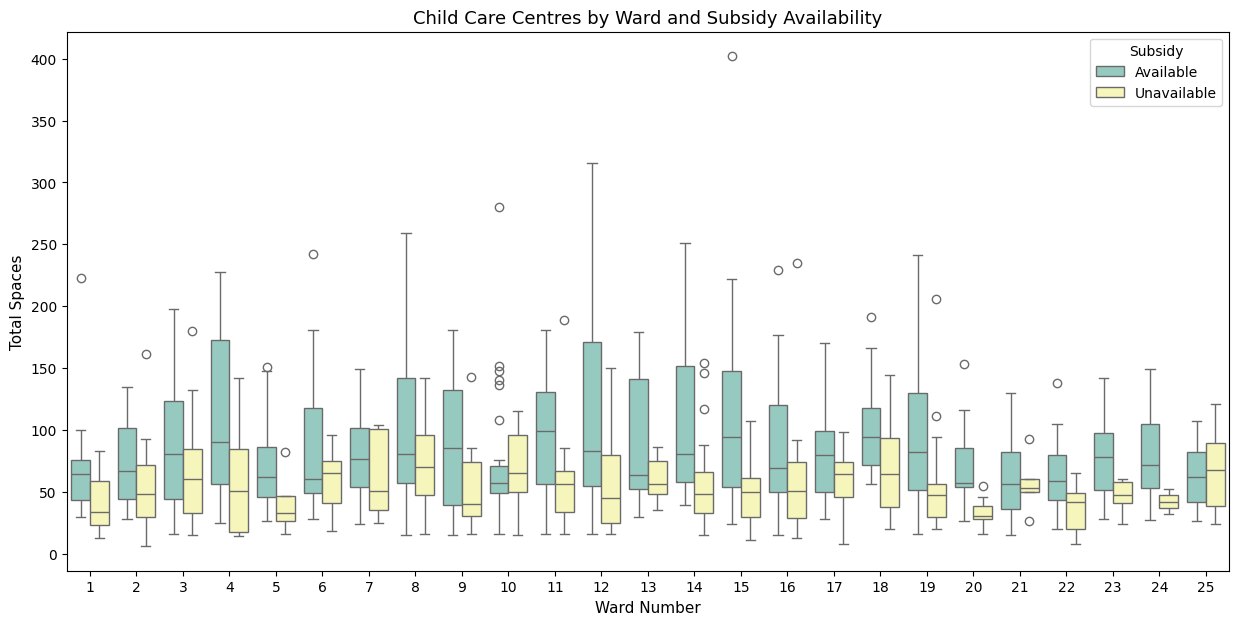

In [74]:
# plot boxplot
plt.figure(figsize=[15, 7])
ax = sns.boxplot(x='Ward', y='Total_Space', hue='Subsidy', data=ward_subsidy, palette='Set3')
ax.set_xlabel('Ward Number', fontsize=11)
ax.set_ylabel('Total Spaces', fontsize=11)
ax.set_title('Child Care Centres by Ward and Subsidy Availability', fontsize=13)

plt.show()

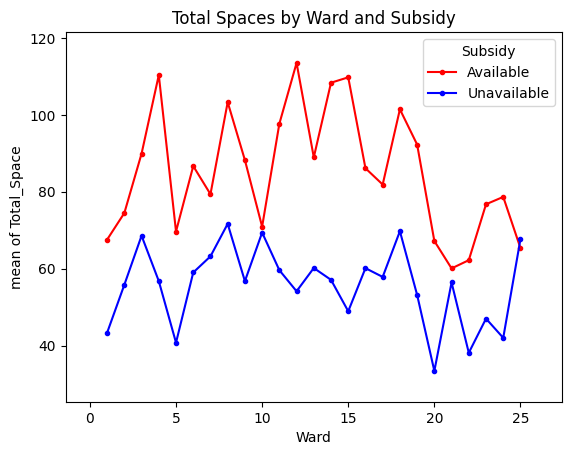

In [75]:
# interaction plot
from statsmodels.graphics.factorplots import interaction_plot

fig = interaction_plot(x = ward_subsidy['Ward'], trace = ward_subsidy['Subsidy'], response = ward_subsidy['Total_Space'], colors=['red', 'blue'])
axes = fig.gca()
axes.set_title('Total Spaces by Ward and Subsidy')

plt.show()

In [76]:
# calculate two-way ANOVA
res = stat()
res.anova_stat(df=ward_subsidy, res_var='Total_Space', anova_model='Total_Space ~ C(Ward) + C(Subsidy) + C(Ward):C(Subsidy)')
round_table(res.anova_summary)

,df,sum_sq,mean_sq,F,PR(>F)
C(Ward),24.0,145685.344,6070.223,2.976,< 0.001
C(Subsidy),1.0,227852.673,227852.673,111.716,< 0.001
C(Ward):C(Subsidy),24.0,55644.003,2318.500,1.137,0.295
Residual,1013.0,2066082.638,2039.568,NaN,NaN


In [77]:
# post-hoc testing of Ward using Tukey's HSD
res = stat()
res.tukey_hsd(df=ward_subsidy, res_var='Total_Space', xfac_var='Ward', anova_model='Total_Space ~ C(Ward) + C(Subsidy) + C(Ward):C(Subsidy)')
round_table(res.tukey_summary)

/usr/local/lib/python3.10/dist-packages/bioinfokit/analys.py:421: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]
/usr/local/lib/python3.10/dist-packages/bioinfokit/analys.py:421: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]
/usr/local/lib/python3.10/dist-packages/bioinfokit/analys.py:421: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to 

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,3,8,5.522,< 0.001,36.631,0.921,0.900
1,3,25,14.631,< 0.001,51.999,2.031,0.900
2,3,10,9.981,< 0.001,42.332,1.601,0.900
3,3,20,21.316,< 0.001,54.534,3.329,0.762
4,3,24,3.783,< 0.001,38.305,0.569,0.900
...,...,...,...,...,...,...,...
295,23,13,12.986,< 0.001,56.518,1.548,0.900
296,23,16,7.067,< 0.001,46.115,0.939,0.900
297,22,13,26.145,< 0.001,67.181,3.305,0.773
298,22,16,20.226,< 0.001,56.470,2.895,0.900


In [78]:
# post-hoc testing of Subsidy using Tukey's HSD
res = stat()
res.tukey_hsd(df=ward_subsidy, res_var='Total_Space', xfac_var='Subsidy', anova_model='Total_Space ~ C(Ward) + C(Subsidy) + C(Ward):C(Subsidy)')
round_table(res.tukey_summary)

/usr/local/lib/python3.10/dist-packages/bioinfokit/analys.py:421: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]
/usr/local/lib/python3.10/dist-packages/bioinfokit/analys.py:421: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]
<ipython-input-65-c67f25b56975>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,Available,Unavailable,26.266,20.46,32.071,12.556,0.001


In [79]:
# post-hoc testing of interaction using Tukey's HSD
res = stat()
res.tukey_hsd(df=ward_subsidy, res_var='Total_Space', xfac_var=['Ward', 'Subsidy'], anova_model='Total_Space ~ C(Ward) + C(Subsidy) + C(Ward):C(Subsidy)')
# resulting table is very large, filter down to treatment levels that show significant p-value
sig_effects = res.tukey_summary[res.tukey_summary['p-value'] < 0.05]
sig_effects.reset_index(drop=True, inplace=True)
round_table(sig_effects)

/usr/local/lib/python3.10/dist-packages/bioinfokit/analys.py:388: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  (df[xfac_var[1]] == ele2)].mean().loc[res_var]
/usr/local/lib/python3.10/dist-packages/bioinfokit/analys.py:388: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  (df[xfac_var[1]] == ele2)].mean().loc[res_var]
/usr/local/lib/python3.10/dist-packages/bioinfokit/analys.py:388: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,"(8, Available)","(20, Unavailable)",69.892,1.811,137.973,5.815,0.034
1,"(8, Available)","(15, Unavailable)",54.375,2.159,106.591,5.898,0.027
2,"(20, Unavailable)","(4, Available)",76.946,9.640,144.253,6.475,0.005
3,"(20, Unavailable)","(14, Available)",74.953,9.883,140.023,6.525,0.004
4,"(20, Unavailable)","(15, Available)",76.350,8.269,144.431,6.352,0.008
5,"(20, Unavailable)","(12, Available)",80.100,11.115,149.085,6.577,0.004
6,"(19, Unavailable)","(4, Available)",57.179,5.978,108.381,6.325,0.008
7,"(19, Unavailable)","(14, Available)",55.186,6.962,103.410,6.482,0.005
8,"(19, Unavailable)","(15, Available)",56.583,4.368,108.799,6.138,0.014
9,"(19, Unavailable)","(12, Available)",60.333,6.944,113.723,6.401,0.006


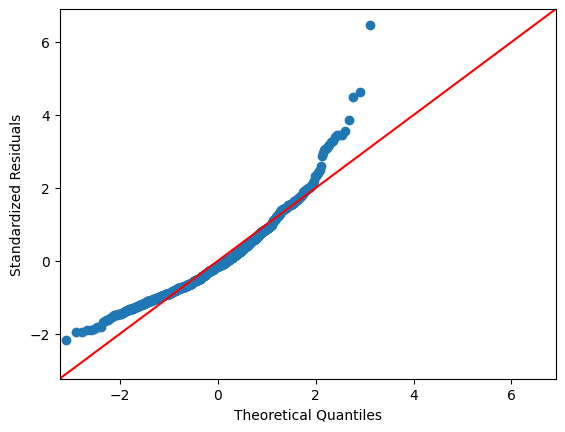

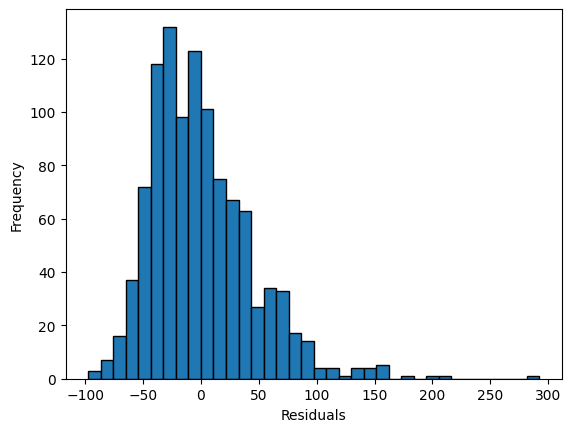

In [80]:
# testing ANOVA assumptions

# assumption 1: residuals follow a normal distribution (using qq plot and histogram)
sm.qqplot(res.anova_std_residuals, line='45')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Standardized Residuals')
plt.show()

plt.hist(res.anova_model_out.resid, bins='auto', histtype='bar', ec='k')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

In [81]:
# testing assumption 1 using Shapiro-Wilk Test
w, pvalue = stats.shapiro(res.anova_model_out.resid)
shapiro_test = pd.DataFrame({'Parameter': ['Test Statistic', 'p-value'], 'Value': [w, pvalue]})
round_table(shapiro_test)

<ipython-input-65-c67f25b56975>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rounded_df[col][x] = round_num(rounded_df[col][x])


,Parameter,Value
0,Test Statistic,0.935
1,p-value,< 0.001


In [82]:
# assumption 2: samples are of equal variance (using Levene's Test)
res = stat()
res.levene(df=ward_subsidy, res_var='Total_Space', xfac_var=['Ward', 'Subsidy'])
round_table(res.levene_summary)

<ipython-input-65-c67f25b56975>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rounded_df[col][x] = round_num(rounded_df[col][x])


,Parameter,Value
0,Test statistics (W),3.024
1,Degrees of freedom (Df),49.0
2,p value,< 0.001
